## Apply the SARWIT to Macquarie Marshes area

In [1]:
#imports
%matplotlib inline
import numpy as np
import datacube
import matplotlib.pyplot as plt
import radar_functions as rf
import radar_gmm as rg
import fiona
from datacube.utils import geometry
import rasterio.features

import xarray as xr

# Import external functions from dea-notebooks
import sys
sys.path.append('./10_Scripts/')
import DEAPlotting, TasseledCapTools, wetlands_insight
#setup radar dc
dc = datacube.Datacube(config='radar.conf')

In [221]:
import imp
imp.reload(rg)

<module 'radar_gmm' from '/g/data1a/r78/rlt118/dea-notebooks/radar_gmm.py'>

In [47]:
#define the region of interest
qtime = ('2016-01-01', '2019-01-01')

query = {
         'time': qtime,
         'lat': (-30.76,-30.62),
         'long': (147.50,147.60)
         }

allSAR = rf.load_cleaned_SAR(query,dc,incidence_angle=True)


In [272]:
#load the pre-fitted model and scaling parameters from pickle files
import pickle
with open("mamukala_full_fit.pkl","rb") as f: ktree = pickle.load(f)
with open("mamukala_scaling_factors.pkl","rb") as f: scaler = pickle.load(f)

In [179]:
allSAR

<xarray.Dataset>
Dimensions:     (time: 87, x: 453, y: 669)
Coordinates:
  * y           (y) float64 -3.439e+06 -3.439e+06 ... -3.422e+06 -3.422e+06
  * x           (x) float64 1.465e+06 1.465e+06 ... 1.476e+06 1.476e+06
  * time        (time) datetime64[ns] 2016-01-12T19:31:02.431269 ... 2018-12-27T19:31:22.731083
Data variables:
    vh          (time, y, x) float32 0.0063037975 0.0068186424 ... 0.007349497
    vv          (time, y, x) float32 0.021188574 0.021478612 ... 0.033884168
    lia         (time, y, x) float32 33.65227 34.233574 ... 37.471 36.411243
    vh_over_vv  (time, y, x) float32 0.29750928 0.31746197 ... 0.21690063

In [180]:
#something weird going on with this scene
allSAR = allSAR.drop(allSAR.time[62].data,dim='time')

In [277]:
bulknormSAR = rf.bulknorm_SAR_ds(np.log(allSAR))

In [278]:
downsampled = rf.downsample_ds(bulknormSAR)

In [279]:
model = rg.SAR_Ktree()
model.fit(downsampled)

In [280]:
all_out = model.predict_dataset(bulknormSAR)

In [287]:
#landcover class map
cover_dict = [3,4,3,2,3,2,1,1,0]
model.landcover_dict = cover_dict

In [289]:
cover_out=model.predict_dataset(bulknormSAR)

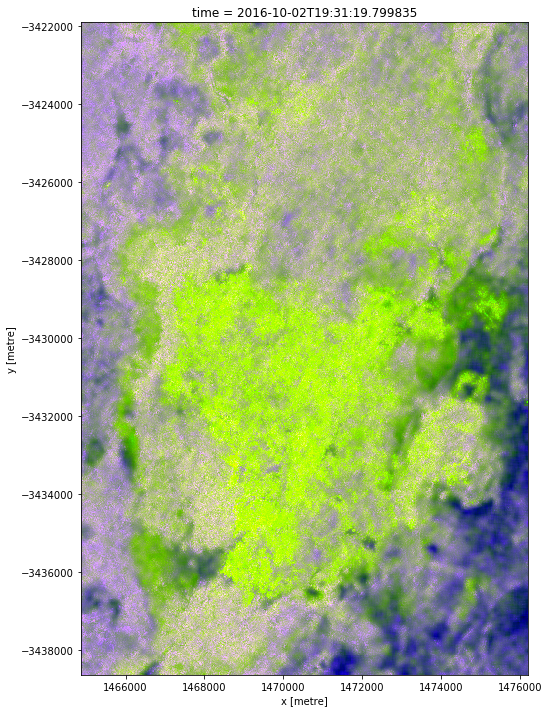

In [206]:
DEAPlotting.rgb(bulknormSAR.isel(time=20),bands=['vh','vv','vh_over_vv'],size=None,figsize=(8,12))

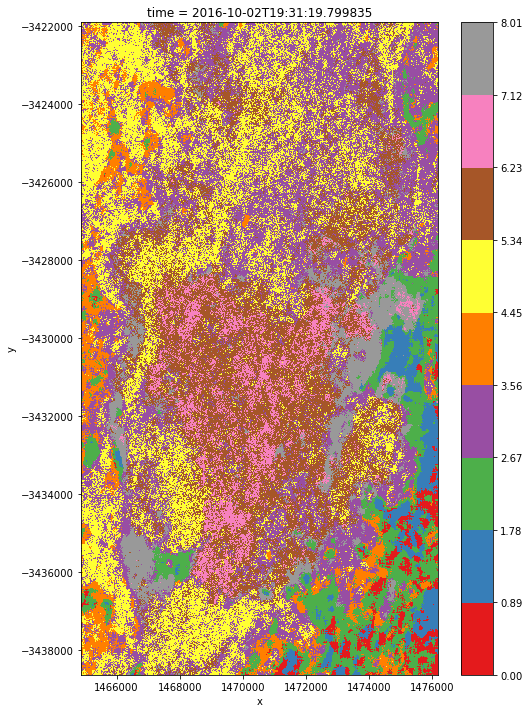

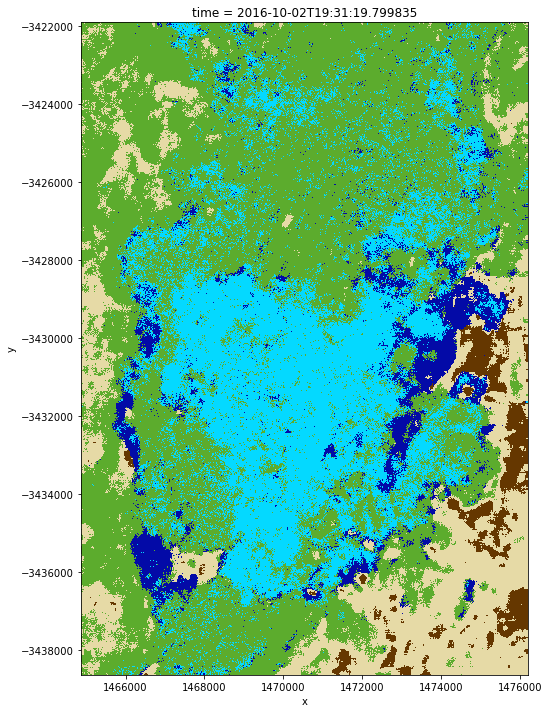

In [290]:
#plot 
import seaborn as sns
pal = [
       sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]
       ]

tind=20
(all_out.isel(time=tind)).plot(vmin=0,vmax=8.01,levels=10,cmap='Set1',size=None,figsize=(8,12))
cover_out.isel(time=tind).plot(vmin = 0, vmax = 4.01, levels=6, colors = pal, add_colorbar=False,figsize=(8,12))

In [52]:
#optical maps
optical_cover = wetlands_insight.WIT_da(query)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 59 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 59 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


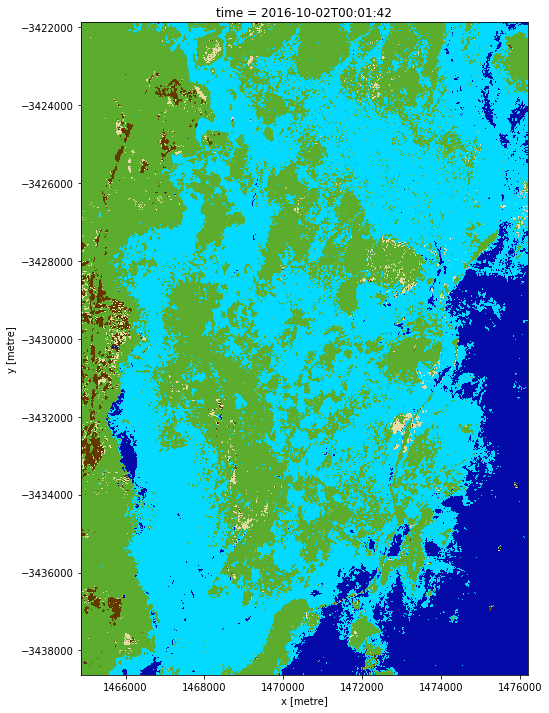

In [286]:
pal_opt = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["brown"],  
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"]]
optical_cover.isel(time=15).plot(vmin = 0, vmax = 4.01, levels=6, colors = pal_opt, add_colorbar=False,figsize=(8,12))

In [291]:
class_ts = rg.tree_timeseries(bulknormSAR,model)

In [228]:
wit_arr = wetlands_insight.WIT_array(query)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 53 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 53 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [230]:
wit_arr

<xarray.Dataset>
Dimensions:  (time: 53)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-20T00:01:32.500000 ... 2018-12-27T00:01:20
Data variables:
    water    (time) float64 0.001738 0.01647 0.005931 ... 0.3125 0.2204 0.06062
    wet      (time) float64 0.007301 0.04777 0.03789 ... 3.847 2.454 0.1489
    green    (time) float64 33.27 32.23 28.68 21.95 ... 24.87 29.87 32.26 37.79
    dry      (time) float64 56.69 54.99 61.81 70.44 ... 56.57 51.15 50.03 47.2
    bare     (time) float64 10.03 12.72 9.468 7.593 ... 15.39 14.82 15.04 14.8

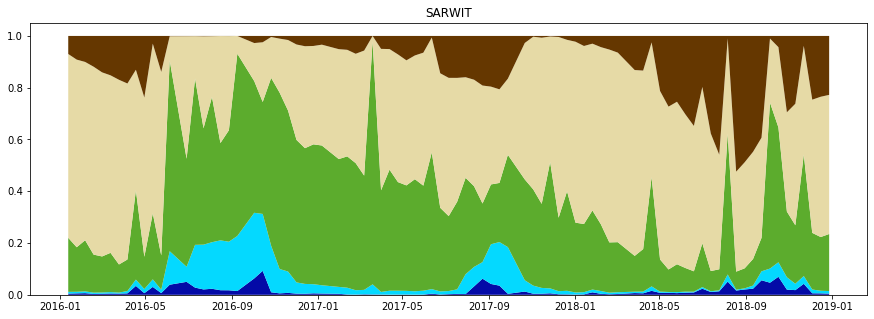

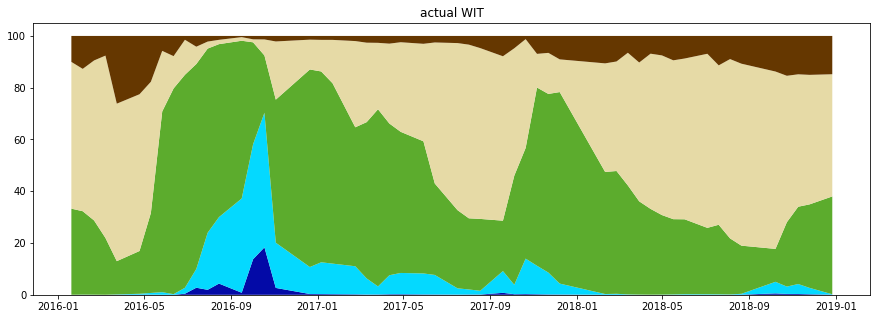

In [294]:
plt.figure(figsize=(15,5));plt.title('SARWIT')
plt.stackplot(class_ts[0].data,class_ts[1].transpose(),colors=pal)
plt.figure(figsize=(15,5));plt.title('actual WIT')
plt.stackplot(wit_arr.time.data,wit_arr.to_array().data,colors=pal)

In [58]:
dcO = datacube.Datacube()
import DEADataHandling
ls8_ds = DEADataHandling.load_clearlandsat(dcO,query)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 68 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


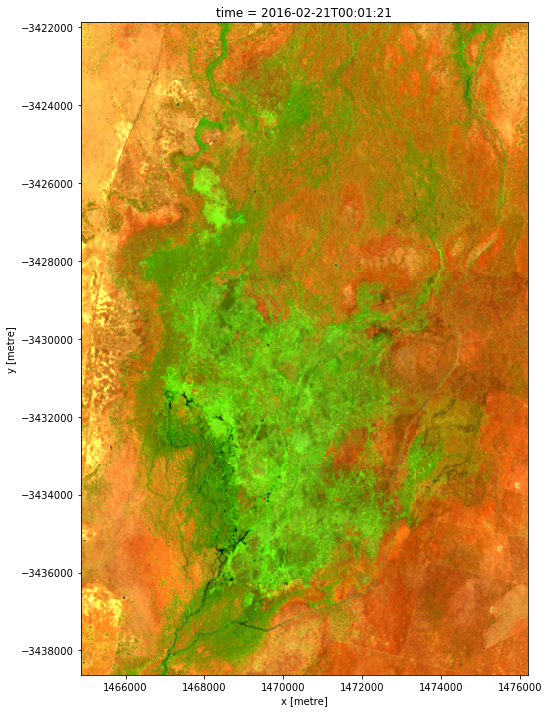

In [284]:
DEAPlotting.rgb(ls8_ds.isel(time=3),bands=['swir1','nir','green'],size=None,figsize=(8,12))